# <center>Titanic dataset


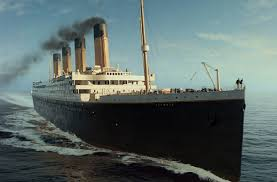

# Classification Machine Learning models using Pyspark

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 49 kB/s 
     |████████████████████████████████| 199 kB 46.6 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=7d5956064da7f59423566d3eadd256e110b262b0a65567a889d7fd58c1d64b76
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [60]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.sql.functions import mean,col,split, col, regexp_extract, when, lit
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import QuantileDiscretizer

In [61]:
spark = SparkSession \
    .builder \
    .appName("Spark ML example on titanic data ") \
    .getOrCreate()

In [62]:
data_path = "train.csv"

In [64]:
titanic_df = spark.read.csv(data_path,header = 'True',inferSchema='True')

In [65]:
passengers_count = titanic_df.count()

In [66]:
print(passengers_count)

891


In [67]:
titanic_df.show(5)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
+-----------+--------+------+--------------------+------+----+-----+-----+------

In [68]:
titanic_df.describe().show()

+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|summary|      PassengerId|           Survived|            Pclass|                Name|   Sex|               Age|             SibSp|              Parch|            Ticket|             Fare|Cabin|Embarked|
+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|  count|              891|                891|               891|                 891|   891|               714|               891|                891|               891|              891|  204|     889|
|   mean|            446.0| 0.3838383838383838| 2.308641975308642|                null|  null| 29.69911764705882|0.5230078563411896|0.38159371492704824|260318.54916792738| 32.20420

In [69]:
titanic_df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [70]:
titanic_df.select("Survived","Pclass","Embarked").show()

+--------+------+--------+
|Survived|Pclass|Embarked|
+--------+------+--------+
|       0|     3|       S|
|       1|     1|       C|
|       1|     3|       S|
|       1|     1|       S|
|       0|     3|       S|
|       0|     3|       Q|
|       0|     1|       S|
|       0|     3|       S|
|       1|     3|       S|
|       1|     2|       C|
|       1|     3|       S|
|       1|     1|       S|
|       0|     3|       S|
|       0|     3|       S|
|       0|     3|       S|
|       1|     2|       S|
|       0|     3|       Q|
|       1|     2|       S|
|       0|     3|       S|
|       1|     3|       C|
+--------+------+--------+
only showing top 20 rows



In [71]:
titanic_df.groupBy("Survived").count().show()

+--------+-----+
|Survived|count|
+--------+-----+
|       1|  342|
|       0|  549|
+--------+-----+



In [72]:
titanic_df.groupBy("Sex","Survived").count().show()

+------+--------+-----+
|   Sex|Survived|count|
+------+--------+-----+
|  male|       0|  468|
|female|       1|  233|
|female|       0|   81|
|  male|       1|  109|
+------+--------+-----+



In [73]:
titanic_df.groupBy("Pclass","Survived").count().show()

+------+--------+-----+
|Pclass|Survived|count|
+------+--------+-----+
|     1|       0|   80|
|     3|       1|  119|
|     1|       1|  136|
|     2|       1|   87|
|     2|       0|   97|
|     3|       0|  372|
+------+--------+-----+



Checking Null values

In [74]:
# This function use to print feature with null values and null count 
def null_value_count(df):
  null_columns_counts = []
  numRows = df.count()
  for k in df.columns:
    nullRows = df.where(col(k).isNull()).count()
    if(nullRows > 0):
      temp = k,nullRows
      null_columns_counts.append(temp)
  return(null_columns_counts)

In [75]:
# Calling function
null_columns_count_list = null_value_count(titanic_df)

In [76]:
null_columns_count_list

[('Age', 177), ('Cabin', 687), ('Embarked', 2)]

In [78]:
spark.createDataFrame(null_columns_count_list, ['Column_With_Null_Value', 'Null_Values_Count']).show()

+----------------------+-----------------+
|Column_With_Null_Value|Null_Values_Count|
+----------------------+-----------------+
|                   Age|              177|
|                 Cabin|              687|
|              Embarked|                2|
+----------------------+-----------------+



In [81]:
mean_age = titanic_df.select(mean('Age')).collect()[0][0]
print(mean_age)

29.69911764705882


To replace these NaN values, we can assign them the mean age of the dataset.But the problem is, there were many people with many different ages. We just cant assign a 4 year kid with the mean age that is 29 years.

we can check the Name feature. Looking upon the feature, we can see that the names have a salutation like Mr or Mrs. Thus we can assign the mean values of Mr and Mrs to the respective groups



In [82]:
titanic_df = titanic_df.withColumn("Initial",regexp_extract(col("Name"),"([A-Za-z]+)\.",1))

In [83]:

titanic_df.show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+-------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|Initial|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+-------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|     Mr|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|    Mrs|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|   Miss|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|    Mrs|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|     Mr|
|          6|   

In [84]:
titanic_df.select("Initial").distinct().show()

+--------+
| Initial|
+--------+
|     Don|
|    Miss|
|Countess|
|     Col|
|     Rev|
|    Lady|
|  Master|
|     Mme|
|    Capt|
|      Mr|
|      Dr|
|     Mrs|
|     Sir|
|Jonkheer|
|    Mlle|
|   Major|
|      Ms|
+--------+



In [85]:
titanic_df = titanic_df.replace(['Mlle','Mme', 'Ms', 'Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
               ['Miss','Miss','Miss','Mr','Mr',  'Mrs',  'Mrs',  'Other',  'Other','Other','Mr','Mr','Mr'])

In [86]:
titanic_df.select("Initial").distinct().show()

+-------+
|Initial|
+-------+
|   Miss|
|  Other|
| Master|
|     Mr|
|    Mrs|
+-------+



In [87]:
titanic_df.groupby('Initial').avg('Age').collect()

[Row(Initial='Miss', avg(Age)=21.86),
 Row(Initial='Other', avg(Age)=45.888888888888886),
 Row(Initial='Master', avg(Age)=4.574166666666667),
 Row(Initial='Mr', avg(Age)=32.73960880195599),
 Row(Initial='Mrs', avg(Age)=35.981818181818184)]


Let's impute missing values in age feature based on average age of Initials

In [88]:
titanic_df = titanic_df.withColumn("Age",when((titanic_df["Initial"] == "Miss") & (titanic_df["Age"].isNull()), 22).otherwise(titanic_df["Age"]))
titanic_df = titanic_df.withColumn("Age",when((titanic_df["Initial"] == "Other") & (titanic_df["Age"].isNull()), 46).otherwise(titanic_df["Age"]))
titanic_df = titanic_df.withColumn("Age",when((titanic_df["Initial"] == "Master") & (titanic_df["Age"].isNull()), 5).otherwise(titanic_df["Age"]))
titanic_df = titanic_df.withColumn("Age",when((titanic_df["Initial"] == "Mr") & (titanic_df["Age"].isNull()), 33).otherwise(titanic_df["Age"]))
titanic_df = titanic_df.withColumn("Age",when((titanic_df["Initial"] == "Mrs") & (titanic_df["Age"].isNull()), 36).otherwise(titanic_df["Age"]))

In [89]:
titanic_df.filter(titanic_df.Age==46).select("Initial").show()


+-------+
|Initial|
+-------+
|     Mr|
|     Mr|
|     Mr|
+-------+



In [90]:
titanic_df.select("Age").show()

+----+
| Age|
+----+
|22.0|
|38.0|
|26.0|
|35.0|
|35.0|
|33.0|
|54.0|
| 2.0|
|27.0|
|14.0|
| 4.0|
|58.0|
|20.0|
|39.0|
|14.0|
|55.0|
| 2.0|
|33.0|
|31.0|
|36.0|
+----+
only showing top 20 rows



In [91]:
titanic_df.groupBy("Embarked").count().show()

+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   77|
|    null|    2|
|       C|  168|
|       S|  644|
+--------+-----+



In [92]:
titanic_df = titanic_df.na.fill({"Embarked" : 'S'})

We can drop Cabin features as it has lots of null values

In [93]:
titanic_df = titanic_df.drop("Cabin")

In [94]:
titanic_df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Embarked: string (nullable = false)
 |-- Initial: string (nullable = true)



We can create a new feature called "Family_size" and "Alone" and analyse it. This feature is the summation of Parch(parents/children) and SibSp(siblings/spouses). It gives us a combined data so that we can check if survival rate have anything to do with family size of the passengers

In [95]:
titanic_df = titanic_df.withColumn("Family_Size",col('SibSp')+col('Parch'))

In [96]:
titanic_df.groupBy("Family_Size").count().show()

+-----------+-----+
|Family_Size|count|
+-----------+-----+
|          1|  161|
|          6|   12|
|          3|   29|
|          5|   22|
|          4|   15|
|          7|    6|
|         10|    7|
|          2|  102|
|          0|  537|
+-----------+-----+



In [99]:
titanic_df = titanic_df.withColumn('Alone',lit(0))

In [100]:
titanic_df.show(5)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+-------+-----------+-----+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Embarked|Initial|Family_Size|Alone|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+-------+-----------+-----+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25|       S|     Mr|          1|    0|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|       C|    Mrs|          1|    0|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925|       S|   Miss|          0|    0|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1|       S|    Mrs|          1|    0|
|          5|       0|     3|Allen, Mr. Willia...|  mal

In [101]:
titanic_df = titanic_df.withColumn("Alone",when(titanic_df["Family_Size"] == 0, 1).otherwise(titanic_df["Alone"]))

In [102]:
titanic_df.columns

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Embarked',
 'Initial',
 'Family_Size',
 'Alone']

In [103]:
titanic_df.show(5)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+-------+-----------+-----+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Embarked|Initial|Family_Size|Alone|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+-------+-----------+-----+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25|       S|     Mr|          1|    0|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|       C|    Mrs|          1|    0|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925|       S|   Miss|          0|    1|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1|       S|    Mrs|          1|    0|
|          5|       0|     3|Allen, Mr. Willia...|  mal

Lets convert Sex, Embarked & Initial columns from string to number using StringIndexer

In [104]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(titanic_df) for column in ["Sex","Embarked","Initial"]]
pipeline = Pipeline(stages=indexers)
titanic_df = pipeline.fit(titanic_df).transform(titanic_df)

In [105]:
titanic_df.show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+-------+-----------+-----+---------+--------------+-------------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Embarked|Initial|Family_Size|Alone|Sex_index|Embarked_index|Initial_index|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+-------+-----------+-----+---------+--------------+-------------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25|       S|     Mr|          1|    0|      0.0|           0.0|          0.0|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|       C|    Mrs|          1|    0|      1.0|           1.0|          2.0|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925|       S|   Miss|          0|  

In [106]:
titanic_df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Embarked: string (nullable = false)
 |-- Initial: string (nullable = true)
 |-- Family_Size: integer (nullable = true)
 |-- Alone: integer (nullable = false)
 |-- Sex_index: double (nullable = false)
 |-- Embarked_index: double (nullable = false)
 |-- Initial_index: double (nullable = false)



Lets convert Sex, Embarked & Initial columns from string to number using StringIndexer

In [107]:
titanic_df = titanic_df.drop("PassengerId","Name","Ticket","Cabin","Embarked","Sex","Initial")

In [108]:
titanic_df.show()

+--------+------+----+-----+-----+-------+-----------+-----+---------+--------------+-------------+
|Survived|Pclass| Age|SibSp|Parch|   Fare|Family_Size|Alone|Sex_index|Embarked_index|Initial_index|
+--------+------+----+-----+-----+-------+-----------+-----+---------+--------------+-------------+
|       0|     3|22.0|    1|    0|   7.25|          1|    0|      0.0|           0.0|          0.0|
|       1|     1|38.0|    1|    0|71.2833|          1|    0|      1.0|           1.0|          2.0|
|       1|     3|26.0|    0|    0|  7.925|          0|    1|      1.0|           0.0|          1.0|
|       1|     1|35.0|    1|    0|   53.1|          1|    0|      1.0|           0.0|          2.0|
|       0|     3|35.0|    0|    0|   8.05|          0|    1|      0.0|           0.0|          0.0|
|       0|     3|33.0|    0|    0| 8.4583|          0|    1|      0.0|           2.0|          0.0|
|       0|     1|54.0|    0|    0|51.8625|          0|    1|      0.0|           0.0|          0.0|


Let's put all features into a vector

In [109]:
feature = VectorAssembler(inputCols=titanic_df.columns[1:],outputCol="features")
feature_vector= feature.transform(titanic_df)

In [110]:
feature_vector.show()

+--------+------+----+-----+-----+-------+-----------+-----+---------+--------------+-------------+--------------------+
|Survived|Pclass| Age|SibSp|Parch|   Fare|Family_Size|Alone|Sex_index|Embarked_index|Initial_index|            features|
+--------+------+----+-----+-----+-------+-----------+-----+---------+--------------+-------------+--------------------+
|       0|     3|22.0|    1|    0|   7.25|          1|    0|      0.0|           0.0|          0.0|(10,[0,1,2,4,5],[...|
|       1|     1|38.0|    1|    0|71.2833|          1|    0|      1.0|           1.0|          2.0|[1.0,38.0,1.0,0.0...|
|       1|     3|26.0|    0|    0|  7.925|          0|    1|      1.0|           0.0|          1.0|[3.0,26.0,0.0,0.0...|
|       1|     1|35.0|    1|    0|   53.1|          1|    0|      1.0|           0.0|          2.0|[1.0,35.0,1.0,0.0...|
|       0|     3|35.0|    0|    0|   8.05|          0|    1|      0.0|           0.0|          0.0|(10,[0,1,4,6],[3....|
|       0|     3|33.0|    0|    

In [111]:
(trainingData, testData) = feature_vector.randomSplit([0.8, 0.2],seed = 11)

**Modelling**

Here is the list of few Classification Algorithms from Spark ML

LogisticRegression

DecisionTreeClassifier

RandomForestClassifier

Gradient-boosted tree classifier

NaiveBayes

**LogisticRegression**

In [112]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="Survived", featuresCol="features")
#Training algo
lrModel = lr.fit(trainingData)
lr_prediction = lrModel.transform(testData)
lr_prediction.select("prediction", "Survived", "features").show()
evaluator = MulticlassClassificationEvaluator(labelCol="Survived", predictionCol="prediction", metricName="accuracy")

+----------+--------+--------------------+
|prediction|Survived|            features|
+----------+--------+--------------------+
|       1.0|       0|(10,[0,1,4,6,8],[...|
|       1.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,6],[1.0,...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       1.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       1.0|       0|(10,[0,1,3,4,5],[...|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|[1.0,58.0,0.0,2.0...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|[2.0,19.0,1.0,1.0...|
+----------

In [113]:
lr_accuracy = evaluator.evaluate(lr_prediction)
print("Accuracy of LogisticRegression is = %g"% (lr_accuracy))
print("Test Error of LogisticRegression = %g " % (1.0 - lr_accuracy))

Accuracy of LogisticRegression is = 0.771277
Test Error of LogisticRegression = 0.228723 


In [ ]:
DecisionTreeClassifier

**DecisionTreeClassifier**

In [114]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol="Survived", featuresCol="features")
dt_model = dt.fit(trainingData)
dt_prediction = dt_model.transform(testData)
dt_prediction.select("prediction", "Survived", "features").show()


+----------+--------+--------------------+
|prediction|Survived|            features|
+----------+--------+--------------------+
|       0.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|(10,[0,1,4,6,8],[...|
|       1.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       1.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,6],[1.0,...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,3,4,5],[...|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|[1.0,58.0,0.0,2.0...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|[2.0,19.0,1.0,1.0...|
+----------

In [115]:
dt_accuracy = evaluator.evaluate(dt_prediction)
print("Accuracy of DecisionTreeClassifier is = %g"% (dt_accuracy))
print("Test Error of DecisionTreeClassifier = %g " % (1.0 - dt_accuracy))

Accuracy of DecisionTreeClassifier is = 0.819149
Test Error of DecisionTreeClassifier = 0.180851 


**RandomForestClassifier**

In [116]:
from pyspark.ml.classification import RandomForestClassifier
rf = DecisionTreeClassifier(labelCol="Survived", featuresCol="features")
rf_model = rf.fit(trainingData)
rf_prediction = rf_model.transform(testData)
rf_prediction.select("prediction", "Survived", "features").show()

+----------+--------+--------------------+
|prediction|Survived|            features|
+----------+--------+--------------------+
|       0.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|(10,[0,1,4,6,8],[...|
|       1.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       1.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,6],[1.0,...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,3,4,5],[...|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|[1.0,58.0,0.0,2.0...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|[2.0,19.0,1.0,1.0...|
+----------

In [117]:
rf_accuracy = evaluator.evaluate(rf_prediction)
print("Accuracy of RandomForestClassifier is = %g"% (rf_accuracy))
print("Test Error of RandomForestClassifier  = %g " % (1.0 - rf_accuracy))

Accuracy of RandomForestClassifier is = 0.819149
Test Error of RandomForestClassifier  = 0.180851 


**Gradient-boosted tree classifier**

In [118]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol="Survived", featuresCol="features",maxIter=10)
gbt_model = gbt.fit(trainingData)
gbt_prediction = gbt_model.transform(testData)
gbt_prediction.select("prediction", "Survived", "features").show()


+----------+--------+--------------------+
|prediction|Survived|            features|
+----------+--------+--------------------+
|       1.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|(10,[0,1,4,6,8],[...|
|       1.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       1.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,6],[1.0,...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,3,4,5],[...|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|[1.0,58.0,0.0,2.0...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|[2.0,19.0,1.0,1.0...|
+----------

In [119]:
gbt_accuracy = evaluator.evaluate(gbt_prediction)
print("Accuracy of Gradient-boosted tree classifie is = %g"% (gbt_accuracy))
print("Test Error of Gradient-boosted tree classifie %g"% (1.0 - gbt_accuracy))

Accuracy of Gradient-boosted tree classifie is = 0.803191
Test Error of Gradient-boosted tree classifie 0.196809


**NaiveBayes**

In [120]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(labelCol="Survived", featuresCol="features")
nb_model = nb.fit(trainingData)
nb_prediction = nb_model.transform(testData)
nb_prediction.select("prediction", "Survived", "features").show()


+----------+--------+--------------------+
|prediction|Survived|            features|
+----------+--------+--------------------+
|       1.0|       0|(10,[0,1,4,6,8],[...|
|       1.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       1.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,4,6,8],[...|
|       1.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,6],[1.0,...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       1.0|       0|(10,[0,1,4,6],[1....|
|       1.0|       0|(10,[0,1,4,6],[1....|
|       1.0|       0|(10,[0,1,2,4,5],[...|
|       1.0|       0|(10,[0,1,3,4,5],[...|
|       1.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       1.0|       0|[1.0,58.0,0.0,2.0...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6,8],[...|
|       1.0|       0|[2.0,19.0,1.0,1.0...|
+----------

In [121]:
nb_accuracy = evaluator.evaluate(nb_prediction)
print("Accuracy of NaiveBayes is  = %g"% (nb_accuracy))
print("Test Error of NaiveBayes  = %g " % (1.0 - nb_accuracy))

Accuracy of NaiveBayes is  = 0.739362
Test Error of NaiveBayes  = 0.260638 


**Support Vector Machine**

In [122]:
from pyspark.ml.classification import LinearSVC
svm = LinearSVC(labelCol="Survived", featuresCol="features")
svm_model = svm.fit(trainingData)
svm_prediction = svm_model.transform(testData)
svm_prediction.select("prediction", "Survived", "features").show()


+----------+--------+--------------------+
|prediction|Survived|            features|
+----------+--------+--------------------+
|       0.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,6],[1.0,...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,3,4,5],[...|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|[1.0,58.0,0.0,2.0...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|[2.0,19.0,1.0,1.0...|
+----------

In [123]:
svm_accuracy = evaluator.evaluate(svm_prediction)
print("Accuracy of Support Vector Machine is = %g"% (svm_accuracy))
print("Test Error of Support Vector Machine = %g " % (1.0 - svm_accuracy))

Accuracy of Support Vector Machine is = 0.808511
Test Error of Support Vector Machine = 0.191489 
